# fraud-analysis-pyspark

# Data Loading

## Import Libraries

In [317]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import matplotlib.pyplot as plt

## Create Spark Session

In [3]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Credit Card Fradulant Check") \
    .getOrCreate()


## Load downloaded JSON file

In [4]:
sample_cc_json = spark.read.json("C:/Users/USER/Downloads/archive/cc_sample_transaction.json")

## Extract the schema & sample data for understanding

In [6]:
sample_cc_json.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)



In [6]:
sample_cc_json.show(5, False, vertical = True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Unnamed: 0             | 0                                                                                                                                                                                                                                                                                     
 amt                    | 4.97                                                                                                                                                                                                                                                                                  
 category               | misc_net                                                   

In [10]:
sample_cc_json.count()

1296675

Done loaded the data from the given link using PySpark. 
- with .printSchema(), confirmed that all fields were initially read as String type
- need to cast certain columns (like amt, is_fraud, and timestamps) into appropriate data types in later steps.
- noticed that the personal_detail column contains nested JSON that needs flattening

# Data Processing 

## Flattening the personal_detail column

#### Check how the personal_detail column look like 

In [12]:
sample_cc_json.select("personal_detail").show(5, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 personal_detail | {"person_name":"Jennifer,Banks,eeeee","gender":"F","address":"{\"street\":\"561 Perry Cove\",\"city\":\"Moravian Falls\",\"state\":\"NC\",\"zip\":\"28654\"}","lat":"36.0788","long":"-81.1781","city_pop":"3495","job":"Psychologist, counselling","dob":"1988-03-09"}               
-RECORD 1------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 personal_detail | {"person_name":"Stephanie,Gill,eeeee","gender":"F","address":"{\"street\":\"43039 Riley

#### now it's just some random string, will parse into a structured format before continue

In [18]:
# Schema for nested address
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True),
])

# Schema for personal_detail
personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True), 
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True),
])

#### Flat personal_detail 

In [20]:
pd_sampleCC_flat = sample_cc_json.withColumn(
    "personal_detail_struct",
    func.from_json(func.col("personal_detail"), personal_detail_schema)
)

#### Flat address

In [22]:
addr_sampleCC_flat = pd_sampleCC_flat.withColumn(
    "address_struct",
    func.from_json(func.col("personal_detail_struct.address"), address_schema)
)

In [24]:
flat_sampleCC_df = addr_sampleCC_flat.select(
    func.col("Unnamed: 0"),
    func.col("trans_date_trans_time"),
    func.col("cc_num"),
    func.col("merchant"),
    func.col("category"),
    func.col("amt"),
    func.col("personal_detail_struct.person_name").alias("person_name"),
    func.col("personal_detail_struct.gender").alias("gender"),
    func.col("address_struct.street").alias("street"),
    func.col("address_struct.city").alias("city"),
    func.col("address_struct.state").alias("state"),
    func.col("address_struct.zip").alias("zip"),
    func.col("personal_detail_struct.lat").alias("lat"),
    func.col("personal_detail_struct.long").alias("long"),
    func.col("personal_detail_struct.city_pop").alias("city_pop"),
    func.col("personal_detail_struct.job").alias("job"),
    func.col("personal_detail_struct.dob").alias("dob"),
    func.col("trans_num"),
    func.col("merch_lat"),
    func.col("merch_long"),
    func.col("is_fraud"),
    func.col("merch_zipcode"),
    func.col("merch_last_update_time"),
    func.col("merch_eff_time"),
    func.col("cc_bic")
)

#### Show the sample 

In [26]:
flat_sampleCC_df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- person_name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- cc_bic: string (nullable 

In [28]:
flat_sampleCC_df.show(5, truncate = False)


+----------+---------------------+----------------+----------------------------------+-------------+------+--------------------+------+----------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+------------------+-----------+--------+-------------+----------------------+----------------+-----------+
|Unnamed: 0|trans_date_trans_time|cc_num          |merchant                          |category     |amt   |person_name         |gender|street                      |city          |state|zip  |lat    |long     |city_pop|job                              |dob       |trans_num                       |merch_lat         |merch_long |is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time  |cc_bic     |
+----------+---------------------+----------------+----------------------------------+-------------+------+--------------------+------+----------------------------+--------------+-----+-----+---

In [30]:
flat_sampleCC_df.limit(5).toPandas()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,person_name,gender,street,city,...,job,dob,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_last_update_time,merch_eff_time,cc_bic
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,"Jennifer,Banks,eeeee",F,561 Perry Cove,Moravian Falls,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,28705,1325376018666,1325376018798532,CITIUS33CHI
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,"Stephanie,Gill,eeeee",F,43039 Riley Greens Suite 393,Orient,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159046999999994,-118.186462,0,None,132537604479,1325376044867960,ADMDUS41
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward@Sanchez,M,594 White Dale Suite 530,Malad City,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,83236,1325376051286,1325376051506840,Null
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0,"Jeremy/White, !",M,9443 Cynthia Court Apt. 038,Boulder,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,None,1325376076365,1325376076794698,DEUTUS33TRF
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler@Garcia,M,408 Bradley Rest,Doe Hill,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,22844,132537618681,1325376186746376,APBCUS61


# Data Quality Checks and Cleaning 

#### Start with NULL value first

In [274]:
flat_sampleCC_df.select([
    func.count(func.when(func.col(c).isNull() | (func.col(c) == ""), c)).alias(c)
    for c in flat_sampleCC_df.columns
]).show(truncate=False, vertical=True)


-RECORD 0------------------------
 Unnamed: 0             | 0      
 trans_date_trans_time  | 0      
 cc_num                 | 0      
 merchant               | 0      
 category               | 0      
 amt                    | 0      
 person_name            | 0      
 gender                 | 0      
 street                 | 0      
 city                   | 0      
 state                  | 0      
 zip                    | 0      
 lat                    | 0      
 long                   | 0      
 city_pop               | 0      
 job                    | 0      
 dob                    | 0      
 trans_num              | 0      
 merch_lat              | 0      
 merch_long             | 0      
 is_fraud               | 0      
 merch_zipcode          | 195973 
 merch_last_update_time | 0      
 merch_eff_time         | 0      
 cc_bic                 | 144381 



In [276]:
flat_sampleCC_df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- person_name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- cc_bic: string (nullable 

#### Clearly we can see merch_zipcode and cc_bic having some null value, fill merch_zipcode and cc_bic with 'NA'. Also we can see some columns like amt, lat, long, city_pop, merch_lat, merch_long should be in number format, need to do cast for these columns as well

In [278]:
df_transform = flat_sampleCC_df

In [279]:
casts = {
    "amt": "double",
    "lat": "double",
    "long": "double",
    "city_pop": "int",
    "merch_lat": "double",
    "merch_long": "double",
}

for c, t in casts.items():
    if c in df_transform.columns:
        df_transform = df_transform.withColumn(c, func.col(c).cast(t))

df_transform.printSchema()
df_transform.select("amt","lat","long","city_pop").show(5)

root
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- person_name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- cc_bic: string (nullable

In [280]:
df_transform = df_transform.fillna({
    "merch_zipcode": "NA",
    "cc_bic": "NA"
})

# Data Transofrmation

#### coming up we have the person_name column, it is a messy one which consider a lot of unrelated symbols, letters and spaces. 

In [283]:
df_transform.filter(func.col("person_name").rlike("[^a-zA-Z ,]")).select("person_name").show(10, truncate=False)

+---------------------+
|person_name          |
+---------------------+
|Edward@Sanchez       |
|Jeremy/White, !      |
|Tyler@Garcia         |
|Melissa@Aguilar      |
|Eddie|Mendez!!!      |
|Theresa@Blackwell    |
|Charles|Robles!!!    |
|Jack@Hill            |
|Christopher@Castaneda|
|Ronald@Carson        |
+---------------------+
only showing top 10 rows


#### Here's the cleaning steps

In [285]:
# Step 1: Clean up symbols -> keep letters, spaces, commas, hyphens, apostrophes
name_clean = func.regexp_replace(func.col("person_name"), r"[^A-Za-z\s,'-]", " ")

# Step 2: Normalize spaces/commas
name_clean = func.regexp_replace(name_clean, r"\s+", " ")
name_clean = func.regexp_replace(name_clean, r",+", " ")
name_clean = func.trim(name_clean)

# Step 3: Split into tokens
tokens = func.split(name_clean, r"\s+")

# Step 4: First name = always first token
first_final = func.when(func.size(tokens) >= 1, func.initcap(tokens.getItem(0))).otherwise("")

# Step 5: Last name = last "valid" token (not 'eeeee', 'noooo', etc.)
# Define invalid endings
invalid_pattern = r"(?i)^(eee+|no+|na+)$"   # matches eeee, nooo, etc.

last_final = func.expr(
    "filter(transform(tokens, x -> initcap(x)), x -> NOT (x rlike '{0}'))[size(filter(transform(tokens, x -> initcap(x)), x -> NOT (x rlike \"{0}\")))-1]".format(invalid_pattern)
)

df_transform = df_transform.withColumn("tokens", tokens) \
    .withColumn("first", first_final) \
    .withColumn("last", last_final) \
    .drop("tokens")
# show some sample
df_transform.select("person_name", "first", "last").show(20, truncate=False)



+-------------------------+-----------+---------+
|person_name              |first      |last     |
+-------------------------+-----------+---------+
|Jennifer,Banks,eeeee     |Jennifer   |Banks    |
|Stephanie,Gill,eeeee     |Stephanie  |Gill     |
|Edward@Sanchez           |Edward     |Sanchez  |
|Jeremy/White, !          |Jeremy     |White    |
|Tyler@Garcia             |Tyler      |Garcia   |
|Jennifer,Conner,eeeee    |Jennifer   |Conner   |
|Kelsey, , Richards NOOOO |Kelsey     |Richards |
|Steven, Williams         |Steven     |Williams |
|Heather, , Chase NOOOO   |Heather    |Chase    |
|Melissa@Aguilar          |Melissa    |Aguilar  |
|Eddie|Mendez!!!          |Eddie      |Mendez   |
|Theresa@Blackwell        |Theresa    |Blackwell|
|Charles|Robles!!!        |Charles    |Robles   |
|Jack@Hill                |Jack       |Hill     |
|Christopher@Castaneda    |Christopher|Castaneda|
|Ronald@Carson            |Ronald     |Carson   |
|Lisa, Mendez             |Lisa       |Mendez   |


In [286]:
df_transform = df_transform.drop("person_name")

#### the column cc_num is a sensitive PII, so do a simple masking for it

In [288]:
# Masking
if "cc_num" in df_transform.columns:
    last4 = func.substring(func.col("cc_num").cast("string"), -4, 4)
    # Compute a variable-length mask for readability
    mask_len = func.greatest(func.length(func.col("cc_num")) - func.lit(4), func.lit(0))
    masked = func.concat(func.regexp_replace(func.lpad(func.lit(""), mask_len, "*"), r"\s+", ""), last4)
    df_transform = df_transform.withColumn("cc_num_masked", masked)

df_transform.select("cc_num","cc_num_masked").show(5, truncate=False)

+----------------+----------------+
|cc_num          |cc_num_masked   |
+----------------+----------------+
|2703186189652095|************2095|
|630423337322    |********7322    |
|38859492057661  |**********7661  |
|3534093764340240|************0240|
|375534208663984 |***********3984 |
+----------------+----------------+
only showing top 5 rows


In [289]:
df_transform = df_transform.drop("cc_num")

#### have a peek on all the time columns, found out some is in epoch format

In [291]:
df_transform.select(
    "trans_date_trans_time",
    "merch_last_update_time",
    "merch_eff_time",
).show(5, truncate=False)

+---------------------+----------------------+----------------+
|trans_date_trans_time|merch_last_update_time|merch_eff_time  |
+---------------------+----------------------+----------------+
|2019-01-01 00:00:18  |1325376018666         |1325376018798532|
|2019-01-01 00:00:44  |132537604479          |1325376044867960|
|2019-01-01 00:00:51  |1325376051286         |1325376051506840|
|2019-01-01 00:01:16  |1325376076365         |1325376076794698|
|2019-01-01 00:03:06  |132537618681          |1325376186746376|
+---------------------+----------------------+----------------+
only showing top 5 rows


#### according to requirements, have to change all time format to YYYY-MM-DD HH:MM.SSSSSS Z in UTC +8 timezone

In [293]:
def epoch_to_timestamp(col):
    col_dbl = func.col(col).cast("double")
    return func.when(func.length(func.col(col)) >= 16,
                     col_dbl / 1_000_000.0  # microseconds
                    ).when(func.length(func.col(col)) >= 12,
                           col_dbl / 1_000.0  # milliseconds
                    ).otherwise(col_dbl)      # seconds

def convert_epoch_column(df, col):
    sec = epoch_to_timestamp(col)
    return df.withColumn(
        col,
        func.date_format(
            func.from_unixtime(sec),  # always UTC
            "yyyy-MM-dd HH:mm:ss.SSSSSS"
        )
    ).withColumn(
        col,
        func.concat_ws(" ", func.col(col), func.lit("+0800"))  # force +0800 suffix
    )

# Apply conversion
# Format trans_date_trans_time into "YYYY-MM-DD HH:mm:ss.SSSSSS +0800"
df_transform = convert_epoch_column(df_transform, "merch_last_update_time")
df_transform = convert_epoch_column(df_transform, "merch_eff_time")
df_transform = df_transform.withColumn(
    "trans_date_trans_time",
    func.concat_ws(
        " ",
        func.date_format(
            func.to_timestamp("trans_date_trans_time", "yyyy-MM-dd HH:mm:ss"),
            "yyyy-MM-dd HH:mm:ss.SSSSSS"
        ),
        func.lit("+0800")
    )
)

df_transform.select("trans_date_trans_time", "merch_last_update_time", "merch_eff_time").show(5, truncate=False)

+--------------------------------+--------------------------------+--------------------------------+
|trans_date_trans_time           |merch_last_update_time          |merch_eff_time                  |
+--------------------------------+--------------------------------+--------------------------------+
|2019-01-01 00:00:18.000000 +0800|2012-01-01 08:00:18.000000 +0800|2012-01-01 08:00:18.000000 +0800|
|2019-01-01 00:00:44.000000 +0800|1974-03-15 07:30:04.000000 +0800|2012-01-01 08:00:44.000000 +0800|
|2019-01-01 00:00:51.000000 +0800|2012-01-01 08:00:51.000000 +0800|2012-01-01 08:00:51.000000 +0800|
|2019-01-01 00:01:16.000000 +0800|2012-01-01 08:01:16.000000 +0800|2012-01-01 08:01:16.000000 +0800|
|2019-01-01 00:03:06.000000 +0800|1974-03-15 07:30:18.000000 +0800|2012-01-01 08:03:06.000000 +0800|
+--------------------------------+--------------------------------+--------------------------------+
only showing top 5 rows


In [294]:
df_transform.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = false)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_zipcode: string (nullable = false)
 |-- merch_last_update_time: string (nullable = false)
 |-- merch_eff_time: string (nullable = false)
 |-- cc_bic: string (nullable = false)
 |-- first: string (nullable = true)
 |-- last: string (nullable = 

### organize the columns

In [296]:
clean_cc_df = df_transform.select(
    func.col("Unnamed: 0"),
    func.col("trans_date_trans_time"),
    func.col("cc_num_masked"),
    func.col("merchant"),
    func.col("category"),
    func.col("amt"),
    func.col("first"),
    func.col("last"),
    func.col("gender"),
    func.col("street"),
    func.col("city"),
    func.col("state"),
    func.col("zip"),
    func.col("lat"),
    func.col("long"),
    func.col("city_pop"),
    func.col("job"),
    func.col("dob"),
    func.col("trans_num"),
    func.col("merch_lat"),
    func.col("merch_long"),
    func.col("is_fraud"),
    func.col("merch_zipcode"),
    func.col("merch_last_update_time"),
    func.col("merch_eff_time"),
    func.col("cc_bic")
)

#### the time columns still in string, change all the time to timestamp format

In [298]:
spark.conf.set("spark.sql.session.timeZone", "Asia/Singapore")

clean_cc_df = (
    clean_cc_df.withColumn(
        "merch_last_update_time",
        func.to_timestamp((func.col("merch_last_update_time") / 1000).cast("long"))
    ).withColumn(
        "merch_eff_time",
        func.to_timestamp((func.col("merch_eff_time") / 1000).cast("long"))
    ).withColumn(
        "trans_date_trans_time",
        func.to_timestamp("trans_date_trans_time", "yyyy-MM-dd HH:mm:ss")
    )
)

In [299]:
clean_cc_df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = false)
 |-- cc_num_masked: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = false)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_zipcode: string (nullable = false)
 |-- merch_last_update_time: timestamp (nullable = true)
 |-- merch_eff_time: timestam

# Data Visualization

In [333]:
# Ensure fraud column is numeric
df_vis = df_transform.withColumn("is_fraud", func.col("is_fraud").cast("int"))

#### Fraud vs Non-Fraud Count

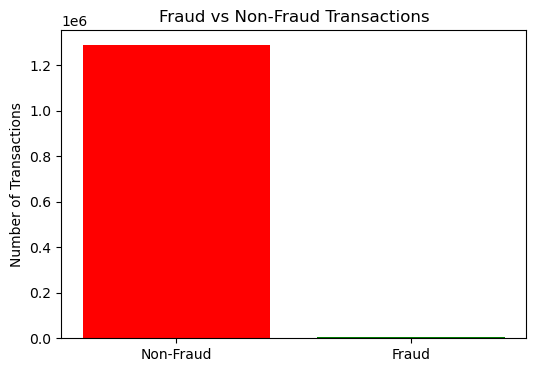

In [321]:
fraud_counts = df_vis.groupBy("is_fraud").count().toPandas()

plt.figure(figsize=(6,4))
plt.bar(fraud_counts["is_fraud"], fraud_counts["count"], color=["green", "red"])
plt.xticks([0,1], ["Non-Fraud", "Fraud"])
plt.title("Fraud vs Non-Fraud Transactions")
plt.ylabel("Number of Transactions")
plt.show()

#### Fraud Rate per Category

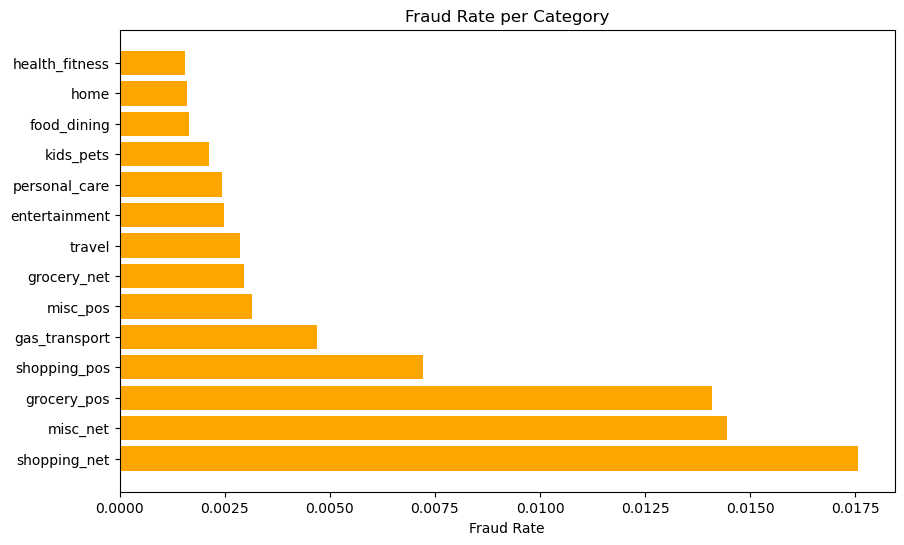

In [325]:
fraud_rate_cat = (
    df_vis.groupBy("category")
    .agg(func.mean("is_fraud").alias("fraud_rate"))
    .orderBy("fraud_rate", ascending=False)
    .toPandas()
)

plt.figure(figsize=(10,6))
plt.barh(fraud_rate_cat["category"], fraud_rate_cat["fraud_rate"], color="orange")
plt.title("Fraud Rate per Category")
plt.xlabel("Fraud Rate")
plt.show()


#### Transaction Amount Trends

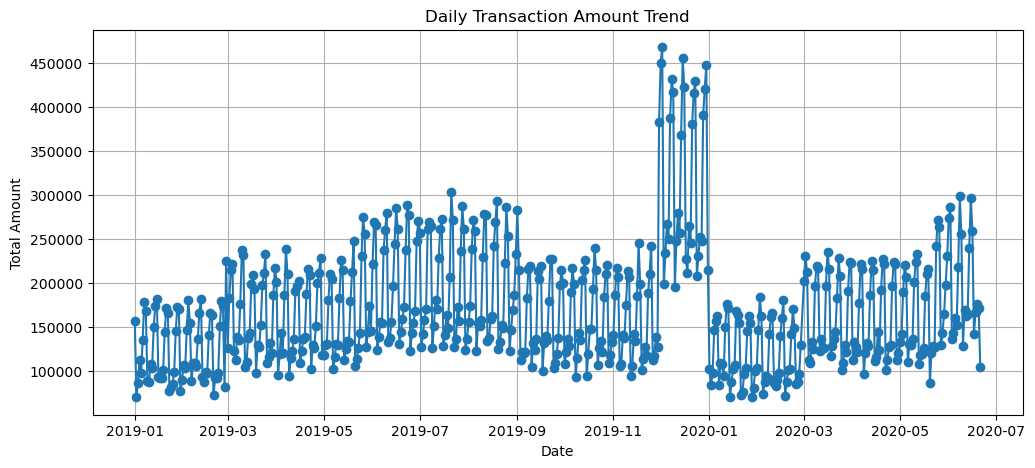

In [327]:
daily_trend = (
    df_vis.withColumn("date", func.to_date("trans_date_trans_time"))
    .groupBy("date")
    .agg(func.sum("amt").alias("total_amt"))
    .orderBy("date")
    .toPandas()
)

plt.figure(figsize=(12,5))
plt.plot(daily_trend["date"], daily_trend["total_amt"], marker="o")
plt.title("Daily Transaction Amount Trend")
plt.xlabel("Date")
plt.ylabel("Total Amount")
plt.grid(True)
plt.show()


#### Fraud Cases by Age Group

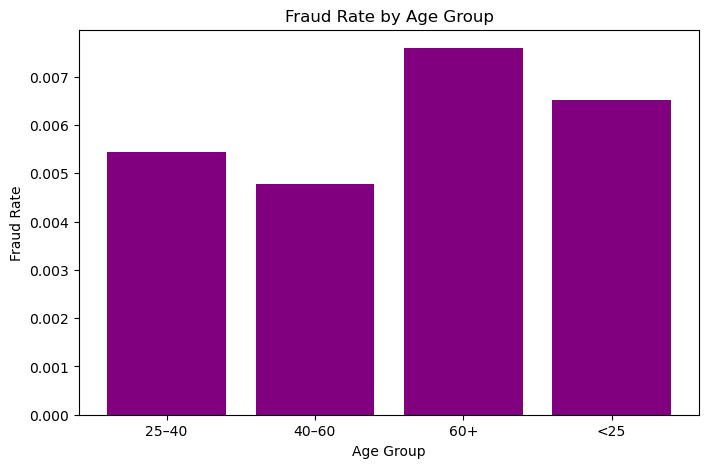

In [329]:
df_age = df_vis.withColumn(
    "age",
    (func.datediff(func.current_date(), func.to_date("dob"))/365.25).cast("int")
)

df_age = df_age.withColumn(
    "age_group",
    func.when(func.col("age") < 25, "<25")
     .when((func.col("age") >= 25) & (func.col("age") < 40), "25–40")
     .when((func.col("age") >= 40) & (func.col("age") < 60), "40–60")
     .otherwise("60+")
)

fraud_by_age = (
    df_age.groupBy("age_group")
    .agg(func.mean("is_fraud").alias("fraud_rate"))
    .orderBy("age_group")
    .toPandas()
)

plt.figure(figsize=(8,5))
plt.bar(fraud_by_age["age_group"], fraud_by_age["fraud_rate"], color="purple")
plt.title("Fraud Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Fraud Rate")
plt.show()


#### Top Merchants by Fraud Rate

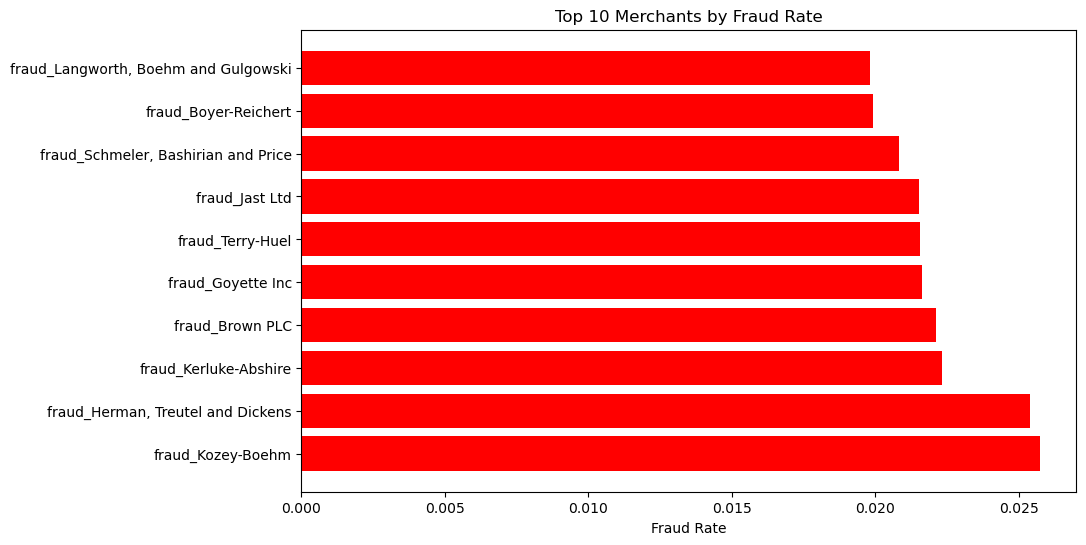

In [331]:
merchant_risk = (
    df_vis.groupBy("merchant")
    .agg(func.mean("is_fraud").alias("fraud_rate"),
         func.count("*").alias("txn_count"))
    .filter("txn_count > 50")   # filter small merchants to avoid noise
    .orderBy("fraud_rate", ascending=False)
    .limit(10)
    .toPandas()
)

plt.figure(figsize=(10,6))
plt.barh(merchant_risk["merchant"], merchant_risk["fraud_rate"], color="red")
plt.title("Top 10 Merchants by Fraud Rate")
plt.xlabel("Fraud Rate")
plt.show()
